**Import Library**

In [1]:
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.functions import col, isnan, when, count, lit, regexp_replace, desc
import pyspark.sql.functions as sf
from pyspark.sql.functions import rank, dense_rank, row_number, percentile_approx
from pyspark.sql.window import Window
from pyspark.sql.types import *
import os
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
spark = SparkSession.builder.config("spark.driver.memory", "7g").config('spark.jars.packages','mysql:mysql-connector-java:8.0.17').getOrCreate()

In [4]:
# Read ETL_Data from MyQSL Server
# url = 'jdbc:mysql://' + 'localhost' + ':' + '3306' + '/' + 'customer_360_platform'
# driver = "com.mysql.cj.jdbc.Driver"
# user = 'root'
# password = ''
# sql = '(select * from data_behavior_daily_) A'
# df = spark.read.format('jdbc').options(url = url, driver = driver, dbtable = sql, user = user, password = password).load()

In [3]:
df = spark.read.csv('C:\\Users\\NKNhu\\Project\\Customer_Behavior\\DF_ETL_CLEAN_\\*.csv', header=True)

In [6]:
df.show(5)

+---------+----------+--------------+--------------+--------------+--------------+-----------+
| Contract|      Date|Relax_Duration|Movie_Duration|Child_Duration|Sport_Duration|TV_Duration|
+---------+----------+--------------+--------------+--------------+--------------+-----------+
|AGAAA0335|2022-04-08|          NULL|          NULL|          NULL|          NULL|       9349|
|AGAAA0335|2022-04-13|          NULL|          NULL|          NULL|          NULL|      11719|
|AGAAA0335|2022-04-16|           143|          NULL|          NULL|          NULL|      10572|
|AGAAA0338|2022-04-15|          NULL|          NULL|          NULL|          NULL|       9357|
|AGAAA0338|2022-04-18|          NULL|          NULL|          NULL|          NULL|       8442|
+---------+----------+--------------+--------------+--------------+--------------+-----------+
only showing top 5 rows



In [7]:
df.printSchema()

root
 |-- Contract: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- Relax_Duration: string (nullable = true)
 |-- Movie_Duration: string (nullable = true)
 |-- Child_Duration: string (nullable = true)
 |-- Sport_Duration: string (nullable = true)
 |-- TV_Duration: string (nullable = true)



In [4]:
df = df.withColumn("Relax_Duration", col("Relax_Duration").cast(LongType())) \
    .withColumn("Movie_Duration", col("Movie_Duration").cast(LongType())) \
    .withColumn("Child_Duration",col("Child_Duration").cast(LongType()))\
    .withColumn("Sport_Duration",col("Sport_Duration").cast(LongType()))\
    .withColumn("TV_Duration",col("TV_Duration").cast(LongType()))

In [9]:
df.printSchema()

root
 |-- Contract: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- Relax_Duration: long (nullable = true)
 |-- Movie_Duration: long (nullable = true)
 |-- Child_Duration: long (nullable = true)
 |-- Sport_Duration: long (nullable = true)
 |-- TV_Duration: long (nullable = true)



# **Statistics Monthly**

**Most_Watch & Taste**

In [5]:
monthly_df = df.drop('Date')

In [5]:
def unpivot_data(df):
    a = df.select('Contract', 'TV_Duration').withColumn('Category', sf.lit('TV_Duration')).withColumnRenamed('TV_Duration', 'TotalDuration')
    b = df.select('Contract', 'Relax_Duration').withColumn('Category', sf.lit('Relax_Duration')).withColumnRenamed('Relax_Duration', 'TotalDuration')
    c = df.select('Contract', 'Movie_Duration').withColumn('Category', sf.lit('Movie_Duration')).withColumnRenamed('Movie_Duration', 'TotalDuration')
    d = df.select('Contract', 'Child_Duration').withColumn('Category', sf.lit('Child_Duration')).withColumnRenamed('Child_Duration', 'TotalDuration')
    e = df.select('Contract', 'Sport_Duration').withColumn('Category', sf.lit('Sport_Duration')).withColumnRenamed('Sport_Duration', 'TotalDuration')
    unpivot_data = a.union(b).union(c).union(d).union(e)
    unpivot_data = unpivot_data.groupBy('Contract', 'Category').sum()
    unpivot_data = unpivot_data.withColumnRenamed('sum(TotalDuration)', 'TotalDuration')
    return unpivot_data

In [7]:
def calculate_contract_taste(df):
    data_pivot = df.groupBy('Contract').pivot('Category').sum('TotalDuration')
    contract_taste = data_pivot.withColumn('Relax_Duration', when(col('Relax_Duration').isNotNull(),'Relax').otherwise(col('Relax_Duration')))
    contract_taste = contract_taste.withColumn('Movie_Duration', when(col('Movie_Duration').isNotNull(),'Movie').otherwise(col('Movie_Duration')))
    contract_taste = contract_taste.withColumn('Child_Duration', when(col('Child_Duration').isNotNull(),'Child').otherwise(col('Child_Duration')))
    contract_taste = contract_taste.withColumn('Sport_Duration', when(col('Sport_Duration').isNotNull(),'Sport').otherwise(col('Sport_Duration')))
    contract_taste = contract_taste.withColumn('TV_Duration', when(col('TV_Duration').isNotNull(),'TV').otherwise(col('TV_Duration')))
    contract_taste = contract_taste.withColumn('Taste', sf.concat_ws('-', *[c for c in contract_taste.columns if c!='Contract']))
    contract_taste = contract_taste.select('Contract', 'Taste')
    return contract_taste

In [8]:
def calculate_most_watch(df):
    windowSpec  = Window.partitionBy("Contract").orderBy(desc("TotalDuration"))
    most_watch = df.withColumn("rank", rank().over(windowSpec))
    most_watch = most_watch.filter(col('rank') == 1)
    most_watch = most_watch.withColumnRenamed('Category', 'Most_Watch')
    most_watch = most_watch.withColumn('Most_Watch', regexp_replace('Most_Watch', '_Duration', ''))
    most_watch = most_watch.select('Contract', 'Most_watch')
    return most_watch

In [9]:
def import_data_to_mysql(data, table_name):
    url = 'jdbc:mysql://' + 'localhost' + ':' + '3306' + '/' + 'customer_360_platform'
    driver = "com.mysql.cj.jdbc.Driver"
    user = 'root'
    password = ''
    data.write.format('jdbc').option('url', url).option('driver', driver).option('dbtable', table_name).option('user', user).option('password', password).mode('append').save()
    return print('Data imported successfully.')

In [10]:
def statistics_monthly(df):
    # Group by lại Contract sau khi bỏ cột Date
    data_unpivot = unpivot_data(df)
    contract_taste = calculate_contract_taste(data_unpivot)
    most_watch = calculate_most_watch(data_unpivot)

    # Find Most_watch and Taste for each Contract
    result = data_unpivot.groupBy('Contract').pivot('Category').sum('TotalDuration')
    result = result.join(contract_taste, 'Contract', 'inner')
    result = result.join(most_watch, 'Contract', 'inner')

    result = result.withColumn('Month', sf.lit('2022-04'))
    result = result.select('Month', 'Contract', 'Child_Duration', 'Movie_Duration', 'Relax_Duration', 'Sport_Duration', 'TV_Duration', 'Taste', 'Most_watch')

    print('-----------Saving Data Statistic Monthly ---------')
    import_data_to_mysql(data = result, table_name = 'data_statistic_monthly')
    result.repartition(1).write.csv('C:\\Users\\NKNhu\\Project\\Customer_Behavior\\DF_Statistic_Monthly', header=True)
    print('Data Saved Successfully.')
    return result

In [11]:
statistics_data = statistics_monthly(monthly_df)

-----------Saving Data Statistic Monthly ---------
Data imported successfully.
Data Saved Successfully.


In [11]:
statistics_data.show(5)

+-------+--------------+--------------+--------------+--------------+--------------+-----------+--------+----------+
|  Month|      Contract|Child_Duration|Movie_Duration|Relax_Duration|Sport_Duration|TV_Duration|   Taste|Most_watch|
+-------+--------------+--------------+--------------+--------------+--------------+-----------+--------+----------+
|2022-04|113.182.209.48|          NULL|          NULL|            89|          NULL|         63|Relax-TV|     Relax|
|2022-04|14.182.110.125|          NULL|          NULL|            92|          NULL|        404|Relax-TV|        TV|
|2022-04|14.189.124.168|          NULL|          NULL|          NULL|          NULL|        147|      TV|        TV|
|2022-04|     AGAAA0338|          NULL|          NULL|          NULL|          NULL|     278633|      TV|        TV|
|2022-04|     AGAAA0342|          NULL|          NULL|           204|          NULL|     117788|Relax-TV|        TV|
+-------+--------------+--------------+--------------+----------

**Top 5 Category groups with the highest customer usage**

In [20]:
statistics_data.groupBy('Taste').count().orderBy(desc('count')).show(5)

+--------------+-------+
|         Taste|  count|
+--------------+-------+
|            TV|1323145|
|      Movie-TV| 246096|
|      Child-TV| 124150|
|Child-Movie-TV|  76568|
|      Relax-TV|  37503|
+--------------+-------+
only showing top 5 rows



> Customers who only watch TV in the highest number, followed by other groups: Movie-TV, Child-TV, Child-Movie-TV, Relax-TV

**Statistics on which Category has the most views by customers**

In [16]:
statistics_data.groupBy('Most_watch').count().orderBy(desc('count')).show()

+----------+-------+
|Most_watch|  count|
+----------+-------+
|        TV|1864915|
|     Movie|  43282|
|     Child|  11089|
|     Relax|    929|
|     Sport|    136|
+----------+-------+



**Use IQR to visualize data**

In [ ]:
# statistics_data = spark.read.csv('C:\\Users\\NKNhu\\Project\\Customer_Behavior\\DF_Statistic_Monthly\\*.csv', header=True)
# statistics_data = statistics_data.withColumn("Relax_Duration", col("Relax_Duration").cast(LongType())) \
#                                  .withColumn("Movie_Duration", col("Movie_Duration").cast(LongType())) \
#                                  .withColumn("Child_Duration",col("Child_Duration").cast(LongType()))\
#                                  .withColumn("Sport_Duration",col("Sport_Duration").cast(LongType()))\
#                                  .withColumn("TV_Duration",col("TV_Duration").cast(LongType()))

In [32]:
def calculate_iqr_point(df, column_name):
    # Calculate bounds
    print('-'*15, column_name)
    quantiles = df.approxQuantile(column_name, [0.25, 0.5, 0.75], 0.01)
    Q1, Q2, Q3 = quantiles[0], quantiles[1], quantiles[2]
    # IQR = Q3 - Q1
    # Q0 = Q1 - 1.5 * IQR
    # Q4 = Q3 + 1.5 * IQR
    print('q1 - 25% :', Q1)
    print('q2 - 50% :', Q2)
    print('q3 - 75% :', Q3)
    return df

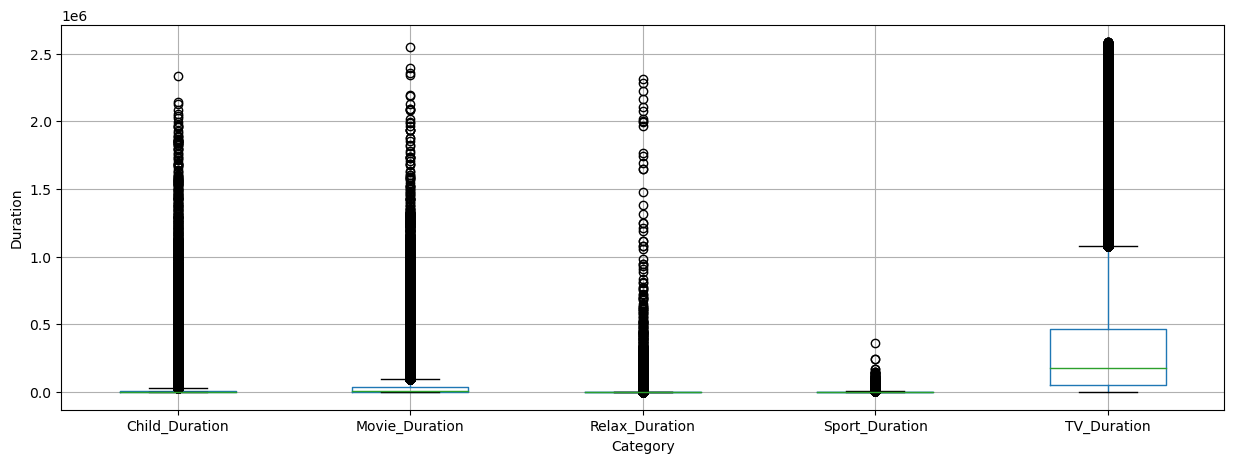

In [27]:
import matplotlib.pyplot as plot

# Print the IQR bounds (25%, 50%, 75%) of each category
iqr_df = statistics_data
no_string_columns = [types[0] for types in iqr_df.dtypes if types[1] != 'string']
for column in no_string_columns:
    calculate_iqr_point(iqr_df, column)

# Plot IQR of each category
df = statistics_data.toPandas()
plot.figure(figsize=(15, 5))
b_plot = df.boxplot(column = ['Child_Duration', 'Movie_Duration', 'Relax_Duration', 'Sport_Duration', 'TV_Duration'])
plot.xlabel('Category')
plot.ylabel('Duration')
b_plot.plot()
plot.show() 

# **RFM Model**

In [6]:
# Keep only latest record for each 'Contract' based on 'Contract' and 'Date'
def calculate_r_score(df):
    # Find last_day_access
    windowSpec = Window.partitionBy('Contract').orderBy(desc('Date'))
    last_date = df.withColumn('Rank',dense_rank().over(windowSpec))
    last_date = last_date.filter(last_date.Rank == 1).drop(last_date.Rank)
    last_date = last_date.select('Contract', 'Date').withColumnRenamed('Date', 'Last_date')

    # Calculate R_Score
    r_score = last_date.withColumnRenamed('Last_date', 'Recency')
    r_score = r_score.withColumn('Recency', (30 - regexp_replace('Recency', '2022-04-', '').cast(IntegerType())))
    # r_score = r_score.orderBy('Recency', ascending=True)
    r_score = r_score.withColumn('R_Score', when(((col('Recency') >= 0) & (col('Recency') <= 5)), 3)
                                           .when(((col('Recency') >= 6) & (col('Recency') <= 14)), 2)
                                           .when(((col('Recency') >= 15) & (col('Recency') <= 30)), 1))
    return r_score

In [7]:
def calculate_f_score(df):
    # Calculate number_date_active
    windowSpec1 = Window.partitionBy('Contract').orderBy('Date')
    windowSpec2 = Window.partitionBy('Contract')

    number_date_active = df.withColumn('row_number', sf.row_number().over(windowSpec1)) \
                        .withColumn('Number_Of_Date', sf.last('row_number').over(windowSpec2)) \
                            .filter('row_number = Number_Of_Date')
    
    number_date_active = number_date_active.select('Contract', 'Number_Of_Date')
    # number_date_active = number_date_active.orderBy('Number_Of_Date', ascending=False)
    number_date_active = number_date_active.withColumnRenamed('Number_Of_Date', 'Frequency')

    # Calculate F_Score
    f_score = number_date_active.withColumn('F_Score', when(((col('Frequency') >= 15) & (col('Frequency') <= 30)), 3)
                                                      .when(((col('Frequency') >= 6) & (col('Frequency') <= 14)), 2)
                                                      .when(((col('Frequency') >= 0) & (col('Frequency') <= 5)), 1))
    return f_score

In [8]:
def calculate_m_score(df):
    # Calculate Totalduration
    df = unpivot_data(df)
    total = df.groupBy('Contract').sum('TotalDuration').withColumnRenamed('sum(TotalDuration)', 'Monetary')
    # total = total.orderBy('Monetary', ascending=False)

    # Calculate F_Score
    seconds_of_month = 2592000
    m_score = total.withColumn('M_Score', when(col('Monetary') >= seconds_of_month*0.6, 3)
                                         .when(col('Monetary') >= seconds_of_month*0.3, 2)
                                         .otherwise(1))
    return m_score

In [9]:
def rfm_segmentation(df):
    r_scores = calculate_r_score(df).drop('Last_date')
    f_scores = calculate_f_score(df)
    m_scores = calculate_m_score(df)

    rfm_data = r_scores.join(f_scores, 'Contract', 'inner')
    rfm_data = rfm_data.join(m_scores, 'Contract', 'inner')
    rfm_data = rfm_data.select('Contract', 'Recency', 'Frequency', 'Monetary', 'R_Score', 'F_Score', 'M_Score')

    score_columns = ['R_Score', 'F_Score', 'M_Score']
    rfm_data = rfm_data.withColumn('RFM_CELL', sf.concat_ws(',', *[c for c in score_columns]))
    rfm_data = rfm_data.withColumn('RFM_SCORE', sf.format_number((col("R_Score") + col("F_Score") + col("M_Score"))/3, 2))

    rfm_data = rfm_data.withColumn('Segment', when((col('RFM_SCORE') >= 2), 'High')
                                             .when((col('RFM_SCORE') >= 1.5), 'Mid')
                                             .otherwise('Low'))
    return rfm_data

In [14]:
rfm_data = rfm_segmentation(df)

In [15]:
rfm_data.show(5)

+--------------+-------+---------+--------+-------+-------+-------+--------+---------+-------+
|      Contract|Recency|Frequency|Monetary|R_Score|F_Score|M_Score|RFM_CELL|RFM_SCORE|Segment|
+--------------+-------+---------+--------+-------+-------+-------+--------+---------+-------+
|113.182.209.48|     29|        1|     152|      1|      1|      1|   1,1,1|     1.00|    Low|
|14.182.110.125|     20|        1|     496|      1|      1|      1|   1,1,1|     1.00|    Low|
|     AGAAA0338|      0|       30|  278633|      3|      3|      1|   3,3,1|     2.33|   High|
|     AGAAA0342|      0|       12|  117992|      3|      2|      1|   3,2,1|     2.00|   High|
|     AGAAA0391|      0|       11|  159433|      3|      2|      1|   3,2,1|     2.00|   High|
+--------------+-------+---------+--------+-------+-------+-------+--------+---------+-------+
only showing top 5 rows



<Axes: title={'center': 'Distribution of customer groups - 04/2022'}, xlabel='Segment'>

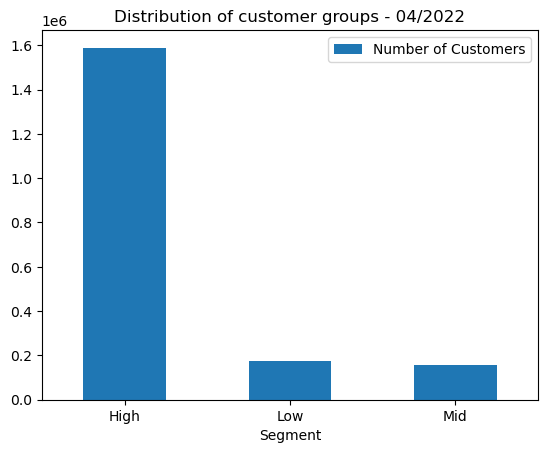

In [16]:
data = rfm_data.groupBy('Segment').count().withColumnRenamed('count', 'Number of Customers').toPandas()
data = data.reindex(["Low", "Mid", "High"])
data.plot.bar(x="Segment", y="Number of Customers", rot=0, title="Distribution of customer groups - 04/2022")

Text(0, 0.5, 'Score')

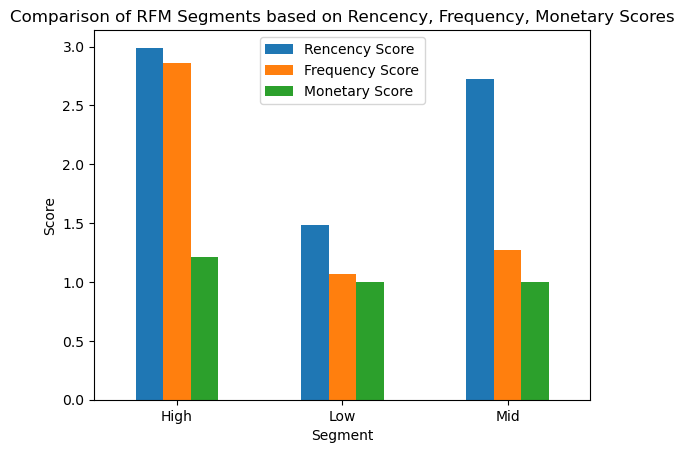

In [36]:
score_data = rfm_data.groupBy('Segment').mean('R_Score', 'F_Score', 'M_Score')
score_data = score_data.toPandas()
score_data = score_data.rename(columns={"avg(R_Score)": "Rencency Score", "avg(F_Score)": "Frequency Score", "avg(M_Score)": "Monetary Score"})
# plotting
score_data.plot.bar(x="Segment", y=["Rencency Score", "Frequency Score", "Monetary Score"], rot=0, title="Comparison of RFM Segments based on Rencency, Frequency, Monetary Scores")
plt.ylabel('Score')